<a href="https://colab.research.google.com/github/blackdragonae/h0wsh2021/blob/main/HubbleConstant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)
**La constantante de Hubble con Galaxias HII**
---



Sincronizando el Drive de google

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalando la librerias de python para hacer los calculos:

In [2]:
!pip install zeus-mcmc
!pip install getdist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for getdist: filename=GetDist-1.4.3-py3-none-any.whl size=227495 sha256=28d7d530d44ffce86e39a607bc49a2b133d3c3370849196747b31b22897e5d63
  Stored in directory: /root/.cache/pip/wheels/35/fe/b3/e3373dbaf0f25d53a2d313d26c2d7fc4a64f3e13d5d9f5c5e7
Successfully built getdist


Importando las librerias necesarias para los calculos

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os
from astropy.table import Table
from astropy.cosmology import FlatwCDM
from getdist import plots, MCSamples
import zeus
from zeus import ChainManager
import numpy as np
import scipy.optimize as op
from multiprocessing import Pool

Función Log Likelihood

In [4]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    alpha, beta, h0 = theta

    Or = 4.153e-5 * h0**(-2)
    Om = 0.3
    w0 = -1.0

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

Definición de los priors

In [5]:
def lnprior(theta):
    alpha, beta, h0 = theta
    if (0.0 <= beta <= 10.0 and 20.0 <= alpha <= 40.0 and 0.5 <= h0 <= 1.0):
        return 0.0
    return -np.inf

Función de Log Posterior

In [6]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

Función de lectura de datos

In [7]:
def h2gdat(dpath):
    LSL = 1.83
    Tpath = dpath+'indat/Union2020v16.dat'
    data = Table.read(Tpath, format='ascii', comment='#')

    vix = data['col1']

    vx = data['col2']
    vy = data['col3']
    vz = data['col4']

    vxErr = data['col5']
    vyErr = data['col6']
    vzErr = data['col7']

    vsp = data['col8']

    rXY = np.corrcoef(vx, vy)
    vRxy = vx*0.0 + rXY[0,1]

    ix = np.where((vx - vxErr) <= LSL)

    return (vix[ix], vx[ix], vy[ix], vz[ix], vxErr[ix], vyErr[ix], vzErr[ix],
            vRxy[ix], vsp[ix])

Inicio del codigo principal, definición del directorio de datos

In [8]:
# Main Code
dpath = '/content/drive/MyDrive/h0wsh2023/dat/'
print('Data path:', dpath)

Data path: /content/drive/MyDrive/h0wsh2023/dat/


Leyendo los datos

In [9]:
# Reading Data
vTg, vx, vy, vz, vxErr, vyErr, vzErr, vRxy, vsp = h2gdat(dpath)

Aproximación inicial para el resultado

In [10]:
# First guess
parameters = [r"\alpha", r"\beta", r"h"]
ialpha = 32.0
ibeta = 5.0
ih0 = 0.75

Cálculo de maximización de probablilidad

In [11]:
# Maximum Likelihood
nll = lambda *args: -lnlike(*args)[0]
result = op.minimize(nll, [ialpha, ibeta, ih0],
                args=(vx, vy, vz, vxErr, vyErr, vzErr)
            )
alpha_ml, beta_ml, h0_ml = result["x"]

print('max llq results:')
print('alpha = ', alpha_ml)
print('beta = ', beta_ml)
print('h = ', h0_ml)

max llq results:
alpha =  33.2169717140405
beta =  5.046006556006849
h =  0.7156989221484847


Cálculo de MCMC

In [12]:
# MCMC
nsteps = 1000
ndim, nwalkers = 3, 10
start = [[alpha_ml, beta_ml, h0_ml] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

#with Pool() as pool:
sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost,
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr)) #, pool=pool)
sampler.run_mcmc(start, nsteps)

sampler.summary

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 3
Number of Walkers: 10
Number of Tuning Generations: 46
Scale Factor: 0.899926
Mean Integrated Autocorrelation Time: 4.95
Effective Sample Size: 2019.92
Number of Log Probability Evaluations: 54858
Effective Samples per Log Probability Evaluation: 0.036821


Visulización de la cadena calculada

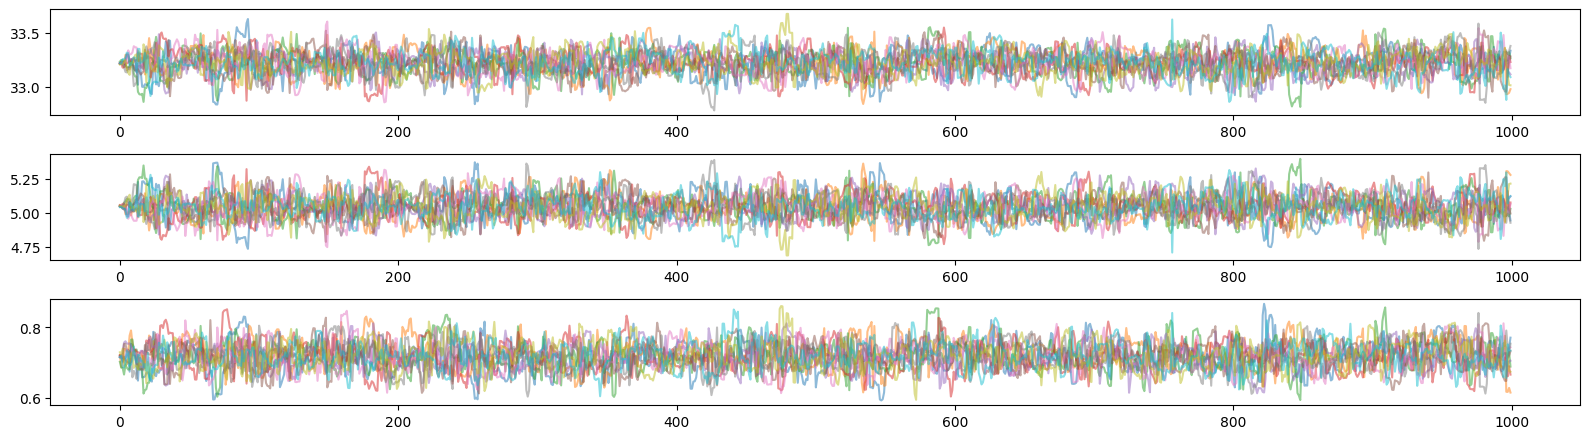

In [13]:
%matplotlib inline
path = dpath+'results/chain_test.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()

Eliminando burn-in y aplanando las cadenas

In [14]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

Graficando resultados

Removed no burn in


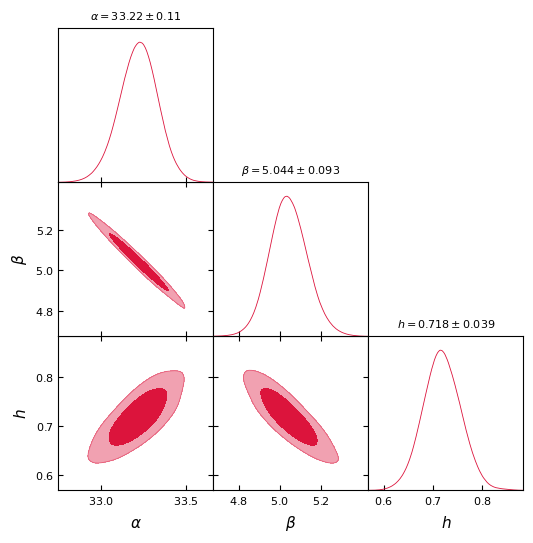

In [15]:
%matplotlib inline
tag = 'GDplot'
path = dpath+'results/GDplot.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag #,
                          # ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)

Imprimiendo los resultados

In [16]:
t = GDsamples.getTable(limit=1).tableTex()
theta = GDsamples.getMeans()

# Print parameter values
print('parameter values:')
for name, col in zip(parameters, chain.transpose()):
  print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))

print(t)

parameter values:
         \alpha : 33.219 +- 0.114
          \beta : 5.044 +- 0.093
              h : 0.718 +- 0.039
\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\alpha         $} & $33.22\pm 0.11             $\\

{\boldmath$\beta          $} & $5.044\pm 0.093            $\\

{\boldmath$h              $} & $0.718\pm 0.039            $\\
\hline
\end{tabular}


**Ejercicio 1:** Con el mismo procedimiento calcualar el conjunto de parametros ${\alpha, \beta, h, \Omega_m}$ utilizando un prior de $0.0 < \Omega_m < 1.0$


In [17]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    alpha, beta, h0, Om = theta

    Or = 4.153e-5 * h0**(-2)
    w0 = -1.0

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

In [18]:
def lnprior(theta):
    alpha, beta, h0, Om = theta
    if (0.0 <= beta <= 10.0 and 20.0 <= alpha <= 40.0 and 0.5 <= h0 <= 1.0 and 0.0 <= Om <= 1.0):
        return 0.0
    return -np.inf

In [19]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

In [20]:
# First guess
parameters = [r"\alpha", r"\beta", r"h", r"\Omega_m"]
ialpha = 32.0
ibeta = 5.0
ih0 = 0.75
iOm = 0.3

In [21]:
# MCMC
nsteps = 1000
ndim, nwalkers = 4, 10
start = [[ialpha, ibeta, ih0, iOm] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

with Pool() as pool:
  sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost, maxiter=20000,
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr), pool=pool)
  sampler.run_mcmc(start, nsteps)

sampler.summary

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 4
Number of Walkers: 10
Number of Tuning Generations: 40
Scale Factor: 0.373795
Mean Integrated Autocorrelation Time: 8.17
Effective Sample Size: 1224.11
Number of Log Probability Evaluations: 77362
Effective Samples per Log Probability Evaluation: 0.015823


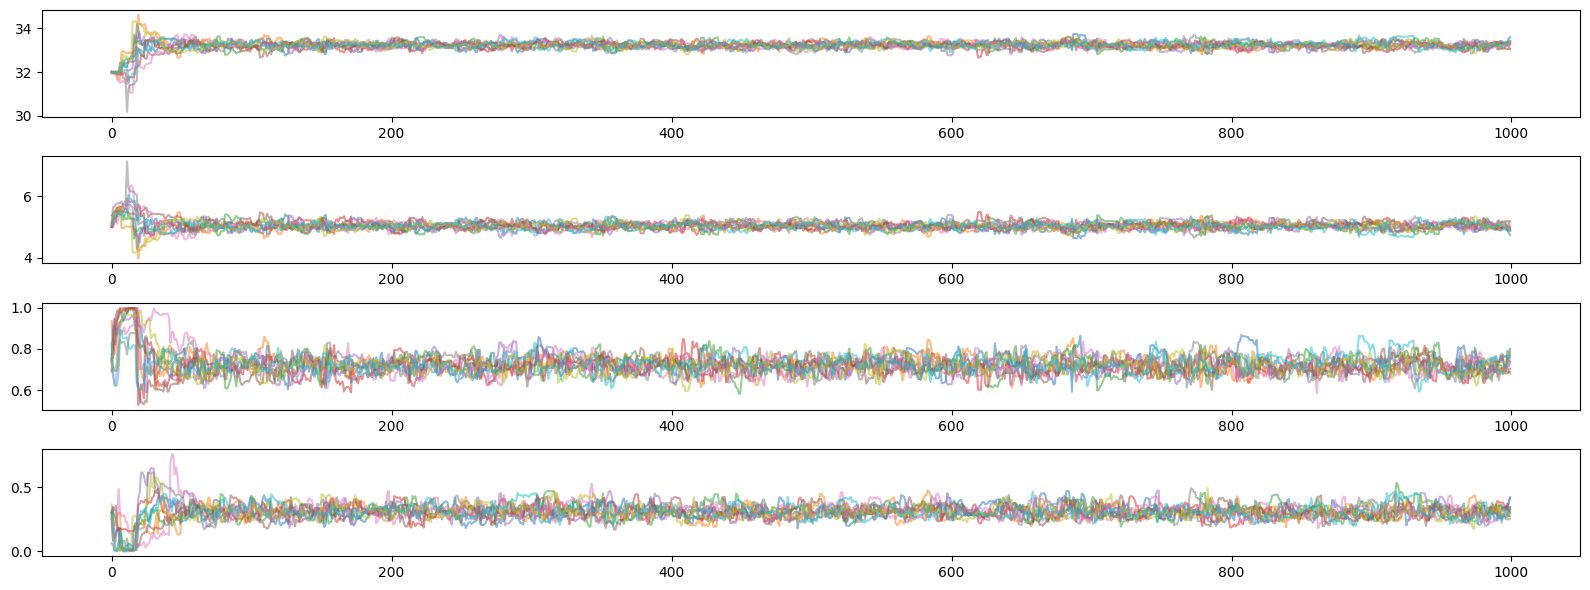

In [22]:
%matplotlib inline
path = dpath+'results/chain_test_Om.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()

In [23]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

Removed no burn in


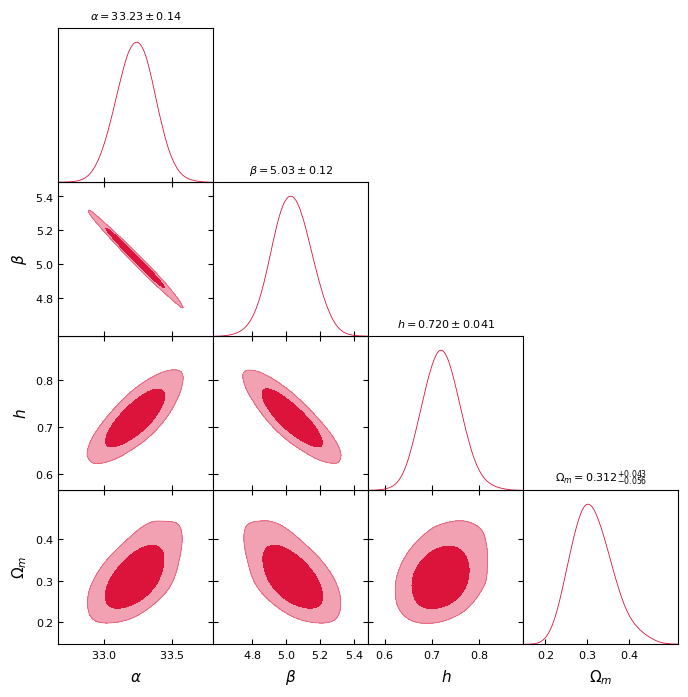

In [24]:
%matplotlib inline
tag = 'GDplot'
path = dpath+'results/GDplotOm.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag
                        , ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)

**Ejercicio 2:** Con el mismo procedimiento calcualar el conjunto de parametros ${\alpha, \beta, h, \Omega_m, w_0}$ utilizando un prior de $0.0 < \Omega_m < 1.0$ y $-2.0 < w_0 < 1.0$

**Ejercicio 3:** Con el mismo procedimiento calcualar $h, \Omega_m, w_0$ fijando los valores de $\alpha = 33.22\pm 0.12$ y $\beta = 5.044\pm 0.094$.

In [25]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    h0, Om, w0 = theta

    Or = 4.153e-5 * h0**(-2)

    alpha = 33.22
    alphaErr = 0.12
    beta = 5.044
    betaErr = 0.094

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2 + x**2*(betaErr)**2 + alphaErr**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

In [26]:
def lnprior(theta):
    h0, Om, w0 = theta
    if (0.5 <= h0 <= 1.0 and 0.0 <= Om <= 1.0 and -2.0 <= w0 <= 1.0):
        return 0.0
    return -np.inf

In [27]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

In [28]:
# First guess
parameters = [r"h_0", r"\Omega_m", r"w_0"]
ih0 = 0.75
iOm = 0.3
iw0 = -1.0


In [29]:
# MCMC
nsteps = 1000
ndim, nwalkers = 3, 10
start = [[ih0, iOm, iw0] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

with Pool() as pool:
  sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost,
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr), pool=pool)
  sampler.run_mcmc(start, nsteps)

sampler.summary

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 3
Number of Walkers: 10
Number of Tuning Generations: 24
Scale Factor: 0.728745
Mean Integrated Autocorrelation Time: 9.8
Effective Sample Size: 1019.98
Number of Log Probability Evaluations: 62720
Effective Samples per Log Probability Evaluation: 0.016262


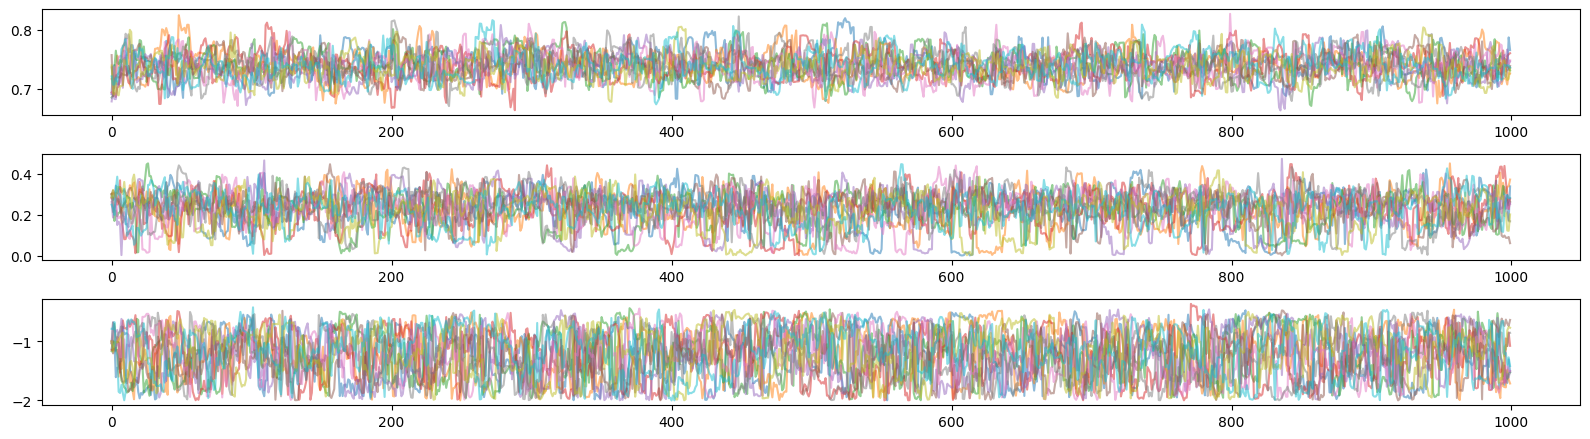

In [30]:
%matplotlib inline
path = dpath+'results/chain_test_w0.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()

In [31]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

Removed no burn in


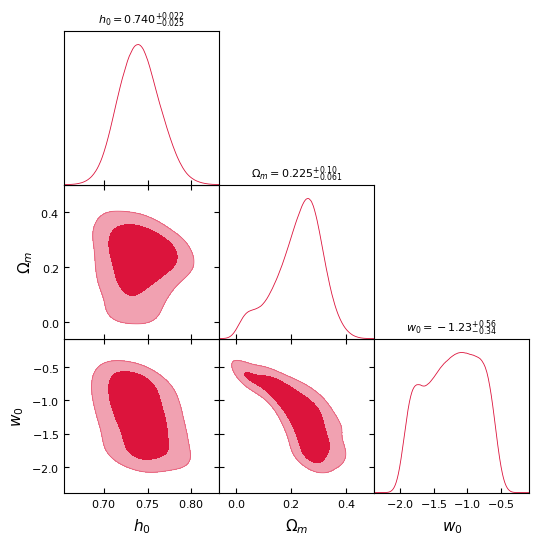

In [32]:
%matplotlib inline
tag = 'GDplot'
path = dpath+'results/GDplotw0.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag #,
                          # ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)